### 1. Problem Introduction

we want to analyze a short-trip prediction problem for the bike-sharing system Divvy in Chicago. Firstly, we define a short ride trip in which the distance between the departure and destination stations is less than 2km. Our goal is to predict whether a given trip is a short one or not. We can download the data from the Divvy website online. Since the data is really large, we utilize the data in 2017 to do predictions. The data includes two parts: information about each trip and information about each station. 

The trip dataset contains variables "start_time", "stop_time", "tripduration", "from_station_name", "to_station_name", "from_station_id", "to_station_id", "usertype", "gender", "birthyear". Since our purpose is to predict whether a bike trip is a short one at the start of the trip, we do not need the variables "stop_time" and "tripduration". In the station dataset, we can know the geograpy information - the latitude and the longitude of each station which can help us calcualte the distance of trips.

### 2. Data Preparation

#### 2.1 Distance Computation

We firstly need to compute the distance between the departure and destination stations in each trip. Since a bike trip can not depart from one station to another as a straight line, we have to consider the Manhattan distance as the trip distance (I think this distance is more reasonable than the direct distance). Another reason for using the Manhattan distance is that  all roads in Chicago are like grid roads.

We use the haversine formula which determines the great-circle distance between two points on a sphere given their longitudes and latitudes: 
$$hav(\frac{d}{r})=hav(\phi_2-\phi_1)+cos(\phi_1)cos(\phi_2)hav(\lambda_2-\lambda_1),$$
where $d$ is the distance between two points, $r$ is the radius of sphere, $\phi_1$ and $\phi_2$ are latitudes for two points and $\lambda_1$ and $\lambda_2$ are longitudes for two points. $hav$ is the haversine function: $hav(\theta)=sin^2(\frac{\theta}{2})$.

Since the directions of streets and avenues in Chicago are respectively similar to the directions of latitude line and longitude line, we do not need to do any rotation in calculation. If we know the latitudes and longitudes for both departure ($\phi_1, \lambda_1$) and destination ($\phi_2, \lambda_2$) stations, we can first calculate the distance $d_1$ between the point   ($\phi_1, \lambda_1$) and the point ($\phi_2, \lambda_1$):
$$hav(\frac{d_1}{r})=hav(\phi_2-\phi_1).$$
Then we can calculate the distance $d_2$ between the point ($\phi_2, \lambda_1$) and the point ($\phi_2, \lambda_2$):
$$hav(\frac{d_2}{r})=cos^2(\phi_2)hav(\lambda_2-\lambda_1).$$

Finally, we can get the Manhattan distance $d=d_1+d_2$ between the departure and destination stations. The code about the distance computation is in the "preprocess_data.py". Then we can assign labels as +1 if the trip distance is less than 2km and assign labels as -1 if not.



#### 2.2 Feature Extraction

To extract the features in this problem, we should consider what factors will influence the trip distance. Generally speaking, the travel behaviors of different categories of people with various travel purposes can be quite different. For example, people with the 24-Hour Pass may travel to some tourist attractions while those subsribers may need riding bikes to work or school. 

We select three types of features with different information. First of all, we consider the features about the user which may have significant influences on the trips. For varialbe "usertype", we define feature $x_1$: $x_1=1$ for "Subscriber" and  $x_1=-1$ for "Customer". For varialbe "gender", We define feature $x_2$: $x_2=1$ for "Male", $x_2=-1$ for "Female" and $x_2=0$ for missing values. For variable "birthyear", we calculate the ages for each rider and use the age as feature $x_3$. In addition, we assign the mean age to the missing values. 

Moreover, we consider the features about the departure time. Since we seldom ride bikes in winter and spring in Chicago, different months may lead to completely different bike trips. Also weekday and hour will have a great impact on the trips. Therefore, we extract 3 features from the start time by all assigning numbers such as (1,2,...,12) for "month", (0,1,...,6) for "weekday" and (0,1,...,23) for "hour".

Lastly, we also think about the features with stations. Different locations for stations are quite different and will affect the rider's decision on which station to return the bike. So we add the latitude and longitude to features.

Thus, we extract 8 features to predict the lables by XGboost method.

### 3 Data Visualization
This part will show the code for feature assignment and data visualizations. The data preprocessing part is in the python file "preprocess_data.py". We can do some visualizations for the features and labels to ensure their relationships. We can plot the distributions of short and long trips with different features to check whether these features have influences on the trips.

In [12]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly
plotly.tools.set_credentials_file(username='SimonXu', api_key='Ub0dpCYaCD2YRR72uv73')

In [3]:
# load the dataset which includes features and labels that we have preprocessed
dataset = pd.read_csv('./preprocess_data.csv')
dataset = dataset.drop(dataset.columns[0], axis=1)

# assign NaN to the unknown type in user type
dataset = dataset.replace('Dependent', np.nan)

# assign 'Subscriber' type as 1, 'Customer' type as -1
dataset = dataset.replace('Subscriber', 1)
dataset = dataset.replace('Customer', -1)

# assign 'Male' gender as 1, 'Female' gender as -1, 'Unknown' gender as 0
dataset = dataset.replace('Male', 1)
dataset = dataset.replace('Female', -1)
dataset = dataset.replace('Unknown', 0)

# assign NaN in 'birthyear' variable as the mean value 
# preserve the values in range(10,100) in 'birthyear'
dataset['birthyear'].fillna(dataset['birthyear'].mean(), inplace=True)
dataset = dataset[dataset['birthyear'] < 100]
dataset = dataset[dataset['birthyear'] > 10]

# drop rows where there is NaN or 0 in 'distance' variable
dataset = dataset[dataset['distance'] != 0]
dataset = dataset.dropna(axis=0, how='any')

From the following plots, we can find that subsribers may tend to have more short trips than customers and particularly male subcribers will go short trips than female. Also we explore the relations between weekdays and trips. We find people will give more short trips from Monday to Friday while give less at weekends. This condition is reasonable since people have to go to work or school on weekdays and those trips can not be very long. while in weekends, people may take long trips to attractions. For the feature "month", we can also find the trip distributions are fairly different between summer an winter due to weather.
The feature "hour" may also have similar results due to rush hours so I do not show them.

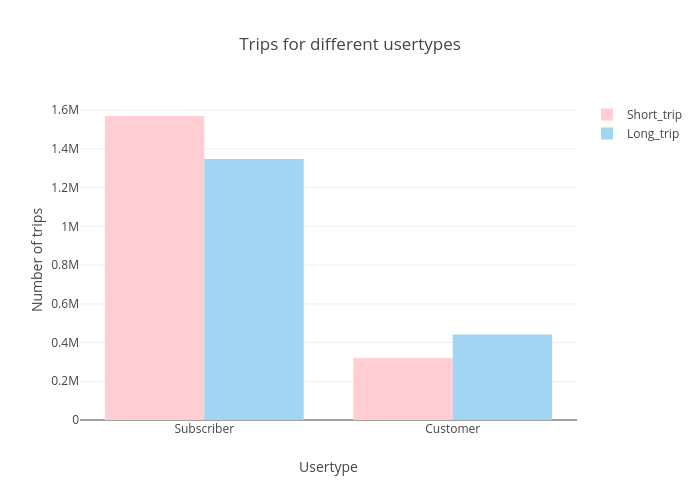

In [13]:
# show the plot about numbers of short and long trips in different usertypes
a1 = (dataset[dataset['usertype'] == 1]['distance'] < 2).sum()
a2 = (dataset[dataset['usertype'] == 1]['distance'] >= 2).sum()
b1 = (dataset[dataset['usertype'] == -1]['distance'] < 2).sum()
b2 = (dataset[dataset['usertype'] == -1]['distance'] >= 2).sum()
d = {'usertype':['Subscriber','Customer'], 'Short_trip':[a1,b1], 'Long_trip':[a2,b2]}
df = pd.DataFrame(data=d)

Short_trip = Bar(x=df.usertype,
                  y=df.Short_trip,
                  name='Short_trip',
                  marker=dict(color='#ffcdd2'))
Long_trip = Bar(x=df.usertype,
                y=df.Long_trip,
                name='Long_trip',
                marker=dict(color='#A2D5F2'))
data = [Short_trip, Long_trip]
layout = Layout(title="Trips for different usertypes",
                xaxis=dict(title='Usertype'),
                yaxis=dict(title='Number of trips'))
fig1 = Figure(data=data, layout=layout)
py.image.ishow(fig1)

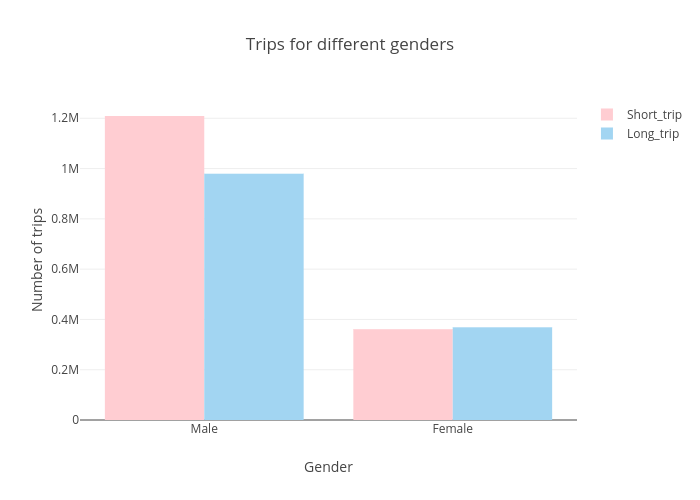

In [14]:
# show the plot about the distribution of trips in different genders
a1 = (dataset[dataset['gender'] == 1]['distance'] < 2).sum()
a2 = (dataset[dataset['gender'] == 1]['distance'] >= 2).sum()
b1 = (dataset[dataset['gender'] == -1]['distance'] < 2).sum()
b2 = (dataset[dataset['gender'] == -1]['distance'] >= 2).sum()
d = {'gender':['Male','Female'], 'Short_trip':[a1,b1], 'Long_trip':[a2,b2]}
df = pd.DataFrame(data=d)

Short_trip = Bar(x=df.gender,
                  y=df.Short_trip,
                  name='Short_trip',
                  marker=dict(color='#ffcdd2'))
Long_trip = Bar(x=df.gender,
                y=df.Long_trip,
                name='Long_trip',
                marker=dict(color='#A2D5F2'))
data = [Short_trip, Long_trip]
layout = Layout(title="Trips for different genders",
                xaxis=dict(title='Gender'),
                yaxis=dict(title='Number of trips'))
fig2 = Figure(data=data, layout=layout)
py.image.ishow(fig2)

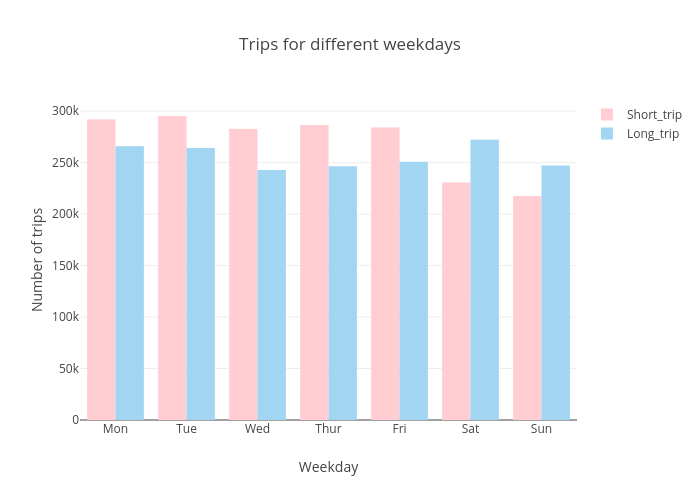

In [15]:
# show the plot about the distribution of trips in different weekdays
Short_trip_count = []
Long_trip_count = []
for v in set(dataset['weekday'].values):
    a1 = (dataset[dataset['weekday'] == v]['distance'] < 2).sum()
    a2 = (dataset[dataset['weekday'] == v]['distance'] >= 2).sum()
    Short_trip_count.append(a1)
    Long_trip_count.append(a2)

d = {'weekday':['Mon','Tue','Wed','Thur','Fri','Sat','Sun'], 
     'Short_trip':Short_trip_count, 'Long_trip':Long_trip_count}
df = pd.DataFrame(data=d)

Short_trip = Bar(x=df.weekday,
                  y=df.Short_trip,
                  name='Short_trip',
                  marker=dict(color='#ffcdd2'))
Long_trip = Bar(x=df.weekday,
                y=df.Long_trip,
                name='Long_trip',
                marker=dict(color='#A2D5F2'))
data = [Short_trip, Long_trip]
layout = Layout(title="Trips for different weekdays",
                xaxis=dict(title='Weekday'),
                yaxis=dict(title='Number of trips'))
fig3 = Figure(data=data, layout=layout)
py.image.ishow(fig3)

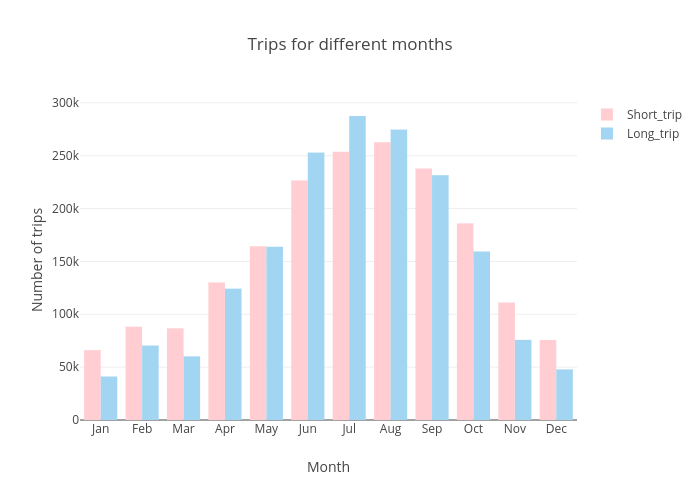

In [16]:
# show the plot about the distribution of trips in different months
Short_trip_count = []
Long_trip_count = []
for v in set(dataset['month'].values):
    a1 = (dataset[dataset['month'] == v]['distance'] < 2).sum()
    a2 = (dataset[dataset['month'] == v]['distance'] >= 2).sum()
    Short_trip_count.append(a1)
    Long_trip_count.append(a2)

d = {'month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
     'Short_trip':Short_trip_count, 'Long_trip':Long_trip_count}
df = pd.DataFrame(data=d)

Short_trip = Bar(x=df.month,
                  y=df.Short_trip,
                  name='Short_trip',
                  marker=dict(color='#ffcdd2'))
Long_trip = Bar(x=df.month,
                y=df.Long_trip,
                name='Long_trip',
                marker=dict(color='#A2D5F2'))
data = [Short_trip, Long_trip]
layout = Layout(title="Trips for different months",
                xaxis=dict(title='Month'),
                yaxis=dict(title='Number of trips'))
fig4 = Figure(data=data, layout=layout)
py.image.ishow(fig4)

We can plot the bubble map for the station distributions in Chicago with the short trip percentage. The bubbles with different colors represent different size of the short trip percentage. As we can see, departure stations in the center of Chicago will lead to less short trips while trips starting from the rim of Chicago maps are more likely to be short. Therefore, geography information of the stations have great impacts on the trips.

In [8]:
# extract all station id with their latitude, longitude and short trip percentage
percentage = []
latitude = []
longitude = []
for v in set(dataset['from_station_id'].values):
    a1 = (dataset[dataset['from_station_id'] == v]['distance'] < 2).sum()
    a2 = (dataset[dataset['from_station_id'] == v]['distance'] >= 2).sum()
    r = a1/(a1+a2)
    percentage.append(r)
    latitude.append(dataset.loc[dataset['from_station_id'] == v, 'latitude'].iloc[0])
    longitude.append(dataset.loc[dataset['from_station_id'] == v, 'longitude'].iloc[0])
station_id = list(set(dataset['from_station_id'].values))
map_data = pd.DataFrame({'station_id': station_id, 'percentage': percentage,'latitude': latitude,'longitude':longitude})
map_data = map_data.sort_values('percentage',ascending=False)

In [9]:
# assign the bubble markers with colors and sizes corresponding to the short percentages 
map_data['text'] = map_data['station_id'].astype(str) + '<br>Percentage' + map_data['percentage'].astype(str)
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
stations = []
scale = 120

for i in range(len(limits)):
    lim = limits[i]
    df_sub = map_data[lim[0]:lim[1]]
    station = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['percentage']*scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    stations.append(station)

In [10]:
# locate the center of the map to the Chicago and plot the bubble map
layout = dict(
        title = 'Short trip percentage at each station',
        showlegend = True,
        geo = dict(
            scope=['Chicago'],
            showland = True,
            show_state_data=True,
            projection=dict( type='albers usa',scale=100),
            landcolor = 'rgb(217, 217, 217)',
            center=dict(
            lat=41.9,
            lon=-87.7),
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict( data=stations, layout=layout)
iplot(fig, validate=False)

### 4. Model Implementation
This part will show the code for label prediction. We will perform the XGboost which is an effective ensemble learning method to do predictions. I also tried logistic regression and random forest before but they gave bad performances. Random forest will be easily overfitting and logistic regression has fairly low accuracy. However, XGboost can combine many weak learners together to improve accuracy and add regularization to avoid overfitting. Therefore, XGboost is a good choice for our problem.

In [11]:
# create the labels and features
dataset = dataset.drop(dataset.columns[6], axis=1)
labels = dataset.values[:,-1]
labels = np.array([1 if x < 2 else -1 for x in labels])
features = dataset.values[:,:-1]

# split the data into training sets and test sets
training_data,test_data,training_labels,test_labels = train_test_split(features,labels,test_size=0.3,random_state=66)

#### We then tune the hyperparameters of XGboost by the cross validation: {'max_depth', 'subsample', 'colsample_bytree','n_estimators', 'reg_alpha'}

In [ ]:
# use cross validation to tune hyperparameters
# since the process takes long time, results will not be shown in this notebook
"""
from sklearn.grid_search import GridSearchCV

# best parameter for test1: {'max_depth': 20, 'subsample': 1, 'colsample_bytree': 0.8}
param_test1 = {
 'max_depth':[5,10,15,20],
  'subsample': [0.6,0.8,1],
 'colsample_bytree': [0.6,0.8,1]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
subsample=0.8, colsample_bytree=0.8, nthread=3, seed=123), 
param_grid = param_test1, scoring='roc_auc',n_jobs=3, iid=False, cv=5)
gsearch1.fit(training_data,training_labels)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# best parameter for test2: {'n_estimators':200, 'reg_alpha': 0.1}
param_test2 = {
 'n_estimators': [100,150,200],
 'reg_alpha':[0.01, 0.1, 1, 10]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=20,
subsample=1, colsample_bytree=0.8, nthread=3, seed=123), 
param_grid = param_test2, scoring='roc_auc',n_jobs=3, iid=False, cv=5)
gsearch2.fit(training_data,training_labels)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_
"""

#### Then we perform the model and plot the learning curve for both training datasets and test datasets. We acheive a training accuracy of 84.50% and a test accuracy of 73.35%. 

In [10]:
# perform XGboost 
gdb = XGBClassifier(n_estimators=200, learning_rate=0.1, 
                    max_depth=20, subsample=1, colsample_bytree=0.8, 
                    nthread=3, seed=123, reg_alpha=0.1)
eval_set = [(training_data, training_labels),(test_data, test_labels)]
gdb.fit(training_data, training_labels, eval_metric=["error"], eval_set=eval_set, verbose=True)
gdb_training_pred = gdb.predict(training_data)
accuracy_score(training_labels, gdb_training_pred)


[0]	validation_0-error:0.326432	validation_1-error:0.356946
[1]	validation_0-error:0.294629	validation_1-error:0.329486
[2]	validation_0-error:0.283281	validation_1-error:0.318703
[3]	validation_0-error:0.253474	validation_1-error:0.295407
[4]	validation_0-error:0.250724	validation_1-error:0.290769
[5]	validation_0-error:0.252051	validation_1-error:0.289829
[6]	validation_0-error:0.247579	validation_1-error:0.285288
[7]	validation_0-error:0.244271	validation_1-error:0.283675
[8]	validation_0-error:0.239911	validation_1-error:0.281324
[9]	validation_0-error:0.240525	validation_1-error:0.281246
[10]	validation_0-error:0.234453	validation_1-error:0.278917
[11]	validation_0-error:0.228359	validation_1-error:0.277104
[12]	validation_0-error:0.225198	validation_1-error:0.276625
[13]	validation_0-error:0.223352	validation_1-error:0.276681
[14]	validation_0-error:0.22383	validation_1-error:0.277023
[15]	validation_0-error:0.221469	validation_1-error:0.276756
[16]	validation_0-error:0.218617	va

[135]	validation_0-error:0.160049	validation_1-error:0.266869
[136]	validation_0-error:0.160042	validation_1-error:0.266862
[137]	validation_0-error:0.159903	validation_1-error:0.266793
[138]	validation_0-error:0.159832	validation_1-error:0.266803
[139]	validation_0-error:0.159761	validation_1-error:0.266734
[140]	validation_0-error:0.159717	validation_1-error:0.266771
[141]	validation_0-error:0.159652	validation_1-error:0.266778
[142]	validation_0-error:0.159546	validation_1-error:0.266848
[143]	validation_0-error:0.15908	validation_1-error:0.266746
[144]	validation_0-error:0.159013	validation_1-error:0.266766
[145]	validation_0-error:0.159023	validation_1-error:0.266754
[146]	validation_0-error:0.158548	validation_1-error:0.266683
[147]	validation_0-error:0.158484	validation_1-error:0.266644
[148]	validation_0-error:0.158345	validation_1-error:0.266635
[149]	validation_0-error:0.15813	validation_1-error:0.266591
[150]	validation_0-error:0.157973	validation_1-error:0.266595
[151]	vali

0.84498626128260135

In [11]:
# test accuracy
gdb_test_pred = gdb.predict(test_data)
accuracy_score(test_labels, gdb_test_pred)

0.73348923897689411

#### The plot shows the classification error of the XGBoost model for each epoch on the training and test datasets. From the curve, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 50 to epoch 75.

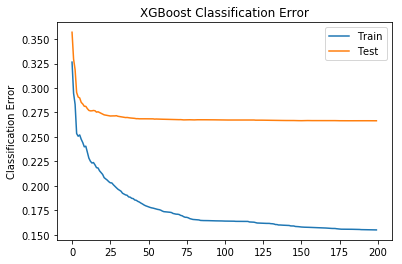

In [12]:
# retrieve performance metrics
results = gdb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

#### We also calculate the feature importance with feature names and plot it with F scores. We surprisingly find that feature "f0" which is "usertype" has the lowest importance and feature "f5" which is "hour" has the highest importance. The probable cause is that the "usertype" an "gender" have fewer possible values which may lead to insignificance in trees. 

In [20]:
# feature importance
feature_names = dataset.columns[:-1].values
fmt = '{:<10}{}'
print(fmt.format('features', 'importance'))
for i,v in enumerate(gdb.feature_importances_):
    print(fmt.format(feature_names[i], v))

features  importance
usertype  0.0075467671267688274
gender    0.03364109247922897
birthyear 0.16422073543071747
month     0.1529453694820404
weekday   0.16047194600105286
hour      0.19895806908607483
latitude  0.16664563119411469
longitude 0.11557038873434067


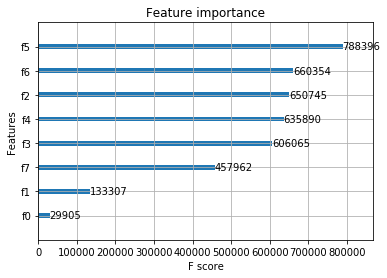

In [21]:
# plot feature importance
xgboost.plot_importance(gdb)
plt.show()

#### We also try to implement feature selection based on feature importance scores. We can set a threshold for the feature importance and  train a model from the selected subset of features to evaluate the performances. However, we find the model does not perform better when doing feature selection so we still perserve all features in the model.

In [27]:
# select features using threshold
thresholds = [0.1,0.15,0.16]
for thresh in thresholds:
    selection = SelectFromModel(gdb, threshold=thresh, prefit=True)
    select_training_data = selection.transform(training_data)
    # train model
    selection_model = XGBClassifier(n_estimators=200, learning_rate=0.1, 
                        max_depth=20, subsample=1, colsample_bytree=0.8, 
                        nthread=3, seed=123, reg_alpha=0.1)
    selection_model.fit(select_training_data, training_labels)
    # eval model
    select_test_data = selection.transform(test_data)
    gdb_test_pred = selection_model.predict(select_test_data)
    accuracy = accuracy_score(test_labels, gdb_test_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_training_data.shape[1], accuracy*100.0))

Thresh=0.100, n=6, Accuracy: 72.21%
Thresh=0.150, n=5, Accuracy: 71.41%
Thresh=0.160, n=4, Accuracy: 70.34%


#### In conclusion, we will choose all 8 features to predict whether a trip is short or not. By using XGboost, we can achieve the test accuracy to 73.35% which is not very good. However, we have implemented the cross validation and regularization to avoid overfitting. Thus the model is quite stable. we can find that the features about the trip start time and station locations have significant influences which is consistent with our analysis at the beginning. Therefore, trips have high relations with users' travel purposes, weather and locations.